# 3.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error


data = pd.read_excel("ВВП.xlsx")
data = data.drop(labels=['Unnamed: 0', 'Unnamed: 1'],axis=1)
series = data.T[0]

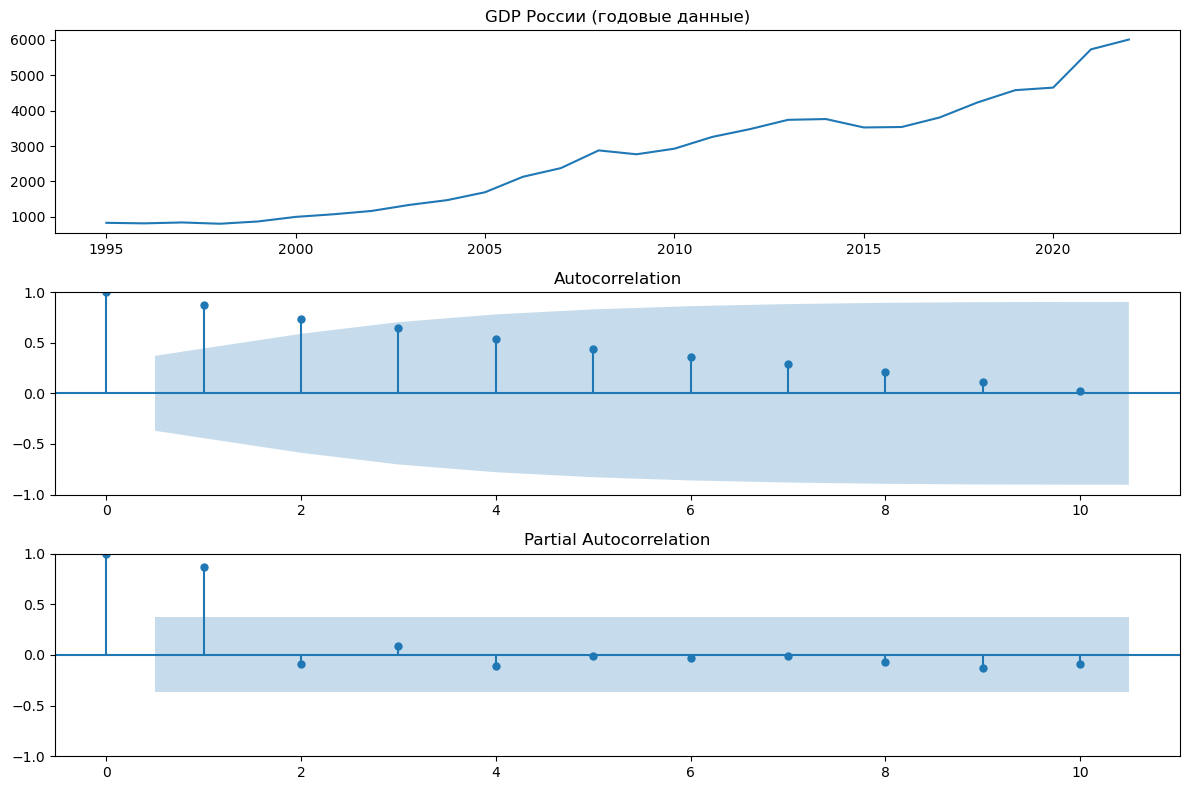

In [113]:
# 3(a)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
series.plot(title='GDP России (годовые данные)')
plt.subplot(3, 1, 2)
plot_acf(series, lags=10, ax=plt.gca())
plt.subplot(3, 1, 3)
plot_pacf(series, lags=10, ax=plt.gca())
plt.tight_layout()
plt.show()


In [114]:
# 3(b)
def adf_test(series):
    result = adfuller(series, regression='ct', autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result

adf_result = adf_test(series)

ADF Statistic: -2.5003789791991777
p-value: 0.3277728462819326
Critical Values:
   1%: -4.441609162283997
   5%: -3.632984327573253
   10%: -3.2547885800150262


In [115]:
# 3(c)
ets_model = ExponentialSmoothing(series, trend='add', seasonal=None).fit()
print("\nETS модель:")
print(ets_model.summary())


ETS модель:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                        0   No. Observations:                   28
Model:             ExponentialSmoothing   SSE                        1625475.898
Optimized:                         True   AIC                            315.135
Trend:                         Additive   BIC                            320.464
Seasonal:                          None   AICC                           319.135
Seasonal Periods:                  None   Date:                 Thu, 12 Jun 2025
Box-Cox:                          False   Time:                         13:47:47
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9872969                alpha                 True
smoothing_trend      

In [116]:
# 3(d)
last_value = series.iloc[-1]
trend = ets_model.params['smoothing_level'] * (1 + ets_model.params['smoothing_trend'])
manual_forecast_1 = last_value + trend
manual_forecast_2 = manual_forecast_1 + trend
residual_std = np.std(ets_model.resid)
z_score = 1.28  # Для 80% доверительного интервала

ci_1_low = manual_forecast_1 - z_score * residual_std
ci_1_high = manual_forecast_1 + z_score * residual_std
ci_2_low = manual_forecast_2 - z_score * residual_std * np.sqrt(2)
ci_2_high = manual_forecast_2 + z_score * residual_std * np.sqrt(2)

In [117]:
print(f"t+1: [{ci_1_low}, {ci_1_high}]")
print(f"t+2: [{ci_2_low}, {ci_2_high}]")

t+1: [5707.904227877779, 6312.571639030121]
t+2: [5583.8114401195635, 6438.940293696236]


In [118]:
# 3(e)
forecast = ets_model.forecast(2)


ARIMA модель:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -187.685
Date:                Thu, 12 Jun 2025   AIC                            381.371
Time:                        13:47:48   BIC                            385.258
Sample:                    01-01-1995   HQIC                           382.527
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9714      0.109      8.897      0.000       0.757       1.185
ma.L1         -0.7663      0.289     -2.651      0.008      -1.333      -0.200
sigma2      6.171e+04   1.18e+04     

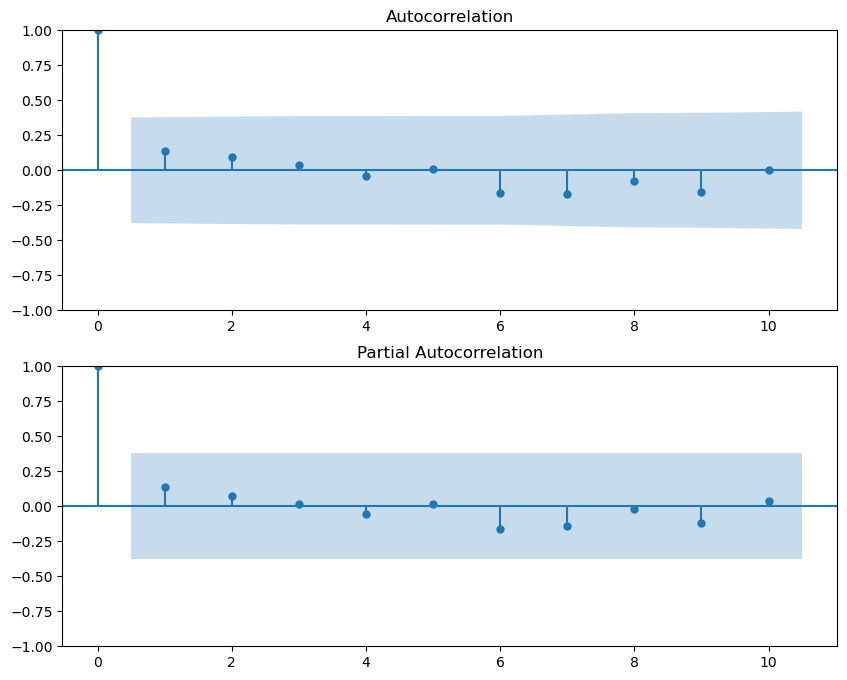

In [119]:
#3(f)
import warnings
warnings.filterwarnings("ignore")

d = 1 if adf_result[1] > 0.05 else 0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(series.diff().dropna(), lags=10, ax=ax1)
plot_pacf(series.diff().dropna(), lags=10, ax=ax2)

arima_model = ARIMA(series, order=(1, d, 1)).fit()
print("\nARIMA модель:")
print(arima_model.summary())

In [120]:
# 3(g)
import warnings
warnings.filterwarnings("ignore")

auto_model = auto_arima(series, seasonal=False, trace=True)
print("\nАвтоматическая ARIMA:")
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=377.145, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=378.707, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=378.753, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=388.251, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=380.702, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.550 seconds

Автоматическая ARIMA:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -186.573
Date:                Thu, 12 Jun 2025   AIC                            377.145
Time:                        13:47:49   BIC                            379.737
Sample:                    01-01-1995   HQIC                           377.9

In [121]:
series.index = pd.to_datetime(series.index.astype(str) + '-01-01')

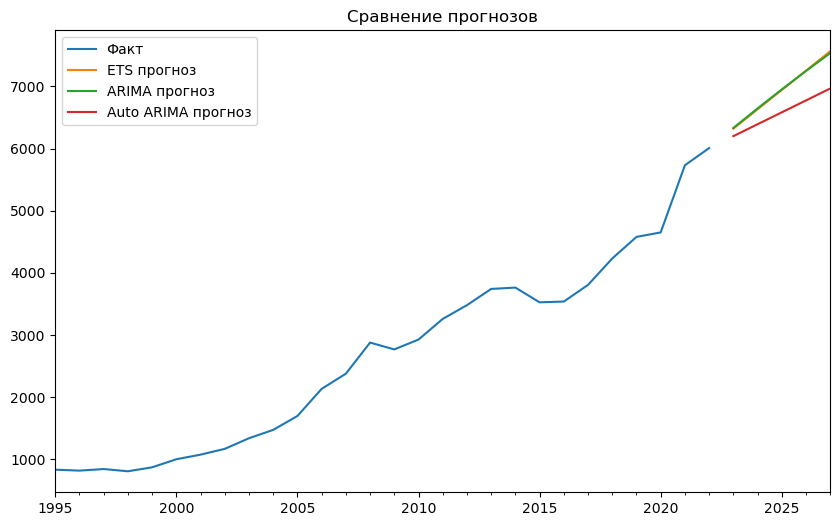

In [122]:
# 3(h)
forecast_ets = ets_model.forecast(5)
forecast_arima = arima_model.forecast(5)
forecast_auto = auto_model.predict(n_periods=5)

plt.figure(figsize=(10, 6))
series.plot(label='Факт')
forecast_ets.plot(label='ETS прогноз')
forecast_arima.plot(label='ARIMA прогноз')
forecast_auto.plot(label='Auto ARIMA прогноз')
plt.legend()
plt.title('Сравнение прогнозов')
plt.show()

# 5.

In [123]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS, RandomEffects

data = pd.read_excel('data_hw_03.xlsx')

data['exper2'] = data['exper']**2
data['year'] = data['year']


In [124]:
# 5(a) 
pooled = smf.ols('lwage ~ educ + black + hisp + exper + exper2 + married + union', data=data).fit()
print("Pooled модель:")
print(pooled.summary())

Pooled модель:
                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     134.5
Date:                Thu, 12 Jun 2025   Prob (F-statistic):          3.28e-178
Time:                        13:47:53   Log-Likelihood:                -2749.5
No. Observations:                3976   AIC:                             5515.
Df Residuals:                    3968   BIC:                             5565.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0671      0.068     

In [125]:
# 5(b) 
data = data.set_index(['nr', 'year'])
re_model = RandomEffects(data.lwage, sm.add_constant(data[['educ', 'black', 'hisp', 'exper', 'exper2', 'married', 'union']]))
re_res = re_model.fit()
print("\nМодель со случайными эффектами:")
print(re_res)




Модель со случайными эффектами:
                        RandomEffects Estimation Summary                        
Dep. Variable:                  lwage   R-squared:                        0.1774
Estimator:              RandomEffects   R-squared (Between):              0.1936
No. Observations:                3976   R-squared (Within):               0.1750
Date:                Thu, Jun 12 2025   R-squared (Overall):              0.1851
Time:                        13:47:53   Log-likelihood                   -1495.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      122.25
Entities:                         497   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(7,3968)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             12

In [126]:
# 5(c) 
fe_model = PanelOLS(data.lwage, sm.add_constant(data[['married', 'union']]), entity_effects=True)
fe_res = fe_model.fit()
print("\nМодель с фиксированными эффектами:")
print(fe_res)




Модель с фиксированными эффектами:
                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0485
Estimator:                   PanelOLS   R-squared (Between):              0.0604
No. Observations:                3976   R-squared (Within):               0.0485
Date:                Thu, Jun 12 2025   R-squared (Overall):              0.0550
Time:                        13:47:53   Log-likelihood                   -1505.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      88.566
Entities:                         497   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(2,3477)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):            

In [127]:
# 5(d)
data_reset = data.reset_index()
for yr in range(81, 88):
    data_reset[f'd{yr}'] = (data_reset['year'] == 1900 + yr).astype(int)
    data_reset[f'd{yr}_educ'] = data_reset[f'd{yr}'] * data_reset['educ']

interaction_terms = ' + '.join([f'd{yr}_educ' for yr in range(81, 88)])
fe_int_model = PanelOLS.from_formula(
    f'lwage ~ married + union + {interaction_terms} + EntityEffects',
    data=data_reset.set_index(['nr', 'year'])
)
fe_int_res = fe_int_model.fit()
print("\nМодель с фиксированными эффектами и взаимодействиями:")
print(fe_int_res)



Модель с фиксированными эффектами и взаимодействиями:
                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1679
Estimator:                   PanelOLS   R-squared (Between):              0.2950
No. Observations:                3976   R-squared (Within):               0.1679
Date:                Thu, Jun 12 2025   R-squared (Overall):              0.2895
Time:                        13:47:53   Log-likelihood                   -1238.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      77.824
Entities:                         497   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(9,3470)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (r

In [128]:
# 5(e)
data_reset['union_lag'] = data_reset.groupby('nr')['union'].shift(-1)
data_lag = data_reset.dropna(subset=['union_lag']).set_index(['nr', 'year'])
fe_lag_model = PanelOLS(data_lag.lwage, sm.add_constant(data_lag[['married', 'union', 'union_lag']]), entity_effects=True)
fe_lag_res = fe_lag_model.fit()
print("\nМодель с фиксированными эффектами и лагированным union:")
print(fe_lag_res)


Модель с фиксированными эффектами и лагированным union:
                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0387
Estimator:                   PanelOLS   R-squared (Between):              0.0682
No. Observations:                3479   R-squared (Within):               0.0387
Date:                Thu, Jun 12 2025   R-squared (Overall):              0.0552
Time:                        13:47:53   Log-likelihood                   -1285.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      39.973
Entities:                         497   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                  F(3,2979)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic 